In [1]:
import sys
print(sys.executable)

c:\Program Files\Python311\python.exe


In [ ]:
# Then import the required libraries
import importlib
import numpy as np
import os
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
# Remove standalone keras imports and use tf.keras instead
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Update keras imports to use tf.keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
# Use tf.keras.models instead
from sklearn.model_selection import GridSearchCV
import joblib

In [ ]:
#all genes

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from tensorflow.keras.models import Sequential

from tensorflow.keras.regularizers import l1, l2, l1_l2
from scikeras.wrappers import KerasClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU, Softmax, ReLU, BatchNormalization, Input, Activation
from keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import time
import pandas as pd

seed = 0
np.random.seed(seed)

# Split data FIRST
X_train = pd.read_csv("X_train.csv").values
X_test = pd.read_csv("X_test.csv").values
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Label encode
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Get number of classes and input dimension
n_classes = len(np.unique(y_train_enc))
input_dim = X_train.shape[1]

print(f"Input dimensions: {input_dim}")
print(f"Number of classes: {n_classes}")

# Create function to build neural network with more options
def create_nn(meta, neurons_layer1=256, neurons_layer2=128, dropout_rate1=0.2, dropout_rate2=0.3, 
              learning_rate=0.002, activation='relu', regularization=None):
    
    # Set regularizer
    if regularization == 'l1':
        reg = l1(1e-15)
    elif regularization == 'l2':
        reg = l2(1e-15)
    elif regularization == 'l1_l2':
        reg = l1_l2(l1=1e-15, l2=1e-15)
    else:
        reg = None

    # Get input dimensions from meta
    n_features_in = meta["n_features_in_"]
    n_classes = meta["n_classes_"]
    
    # Build model
    model = Sequential([
        Dense(neurons_layer1, activation=activation, kernel_regularizer=reg, 
              input_shape=(n_features_in,)),  # Adjust based on feature selection
        Dropout(dropout_rate1),
        Dense(neurons_layer2, activation=activation, kernel_regularizer=reg),
        Dropout(dropout_rate2),
        Dense(n_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap model
nn_model = KerasClassifier(
    model=create_nn, 
    epochs=100, 
    batch_size=16, 
    verbose=0,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
)

# Pipeline with feature selection
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=seed)),
    ('nn', nn_model)
])

# Parameter grid based on the paper
param_grid = {
    # Best from paper: None, ReLU, 0.002, 16, 0.3
    'nn__model__regularization': [None, 'l1', 'l2', 'l1_l2'],
    'nn__model__activation': ['relu', 'tanh', LeakyReLU(negative_slope=0.01)],
    'nn__model__learning_rate': [0.01, 0.002, 0.001, 0.0001, 0.00001, 0.000001],
    'nn__batch_size': [16, 32, 64, 128],
    'nn__model__dropout_rate1': [0.1, 0.2, 0.3],
    'nn__model__dropout_rate2': [0.1, 0.2, 0.3, 0.4, 0.5],
}

# Use RandomizedSearchCV to sample combinations
print("Starting hyperparameter search...")
print(f"Total possible combinations: {4 * 3 * 6 * 4 * 5 * 2 * 2} = {4*3*6*4*5*2*2}")
print("Testing 50 random combinations with 3-fold CV = 150 model trainings\n")

start_time = time.time()

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,  # Test 50 random combinations
    cv=2,  # 3-fold CV (paper uses 5-fold, but 3 is faster)
    scoring='f1_weighted',
    n_jobs=1,  # Use 1 to avoid issues with Keras
    verbose=3,  # Maximum verbosity for progress tracking
    random_state=seed,
    return_train_score=True
)

# Fit with progress tracking
grid_search.fit(X_train, y_train_enc)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60  # Convert to minutes

# Results
print("\n" + "="*80)
print("SEARCH COMPLETE!")
print("="*80)
print(f"\nTotal time: {elapsed_time:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Test on held-out test set
test_acc = grid_search.score(X_test, y_test_enc)
print(f"Test set accuracy: {test_acc:.4f}")

# Create results dataframe
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

# Show top 10 configurations
print("\n" + "="*80)
print("TOP 10 CONFIGURATIONS:")
print("="*80)
top_10 = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")

# Save results to CSV
results_df.to_csv('nn_hyperparameter_search_results.csv', index=False)
print("\n" + "="*80)
print("Full results saved to 'nn_hyperparameter_search_results.csv'")
print("="*80)

Input dimensions: 19277
Number of classes: 5
Starting hyperparameter search...
Total possible combinations: 5760 = 5760
Testing 50 random combinations with 3-fold CV = 150 model trainings

Fitting 2 folds for each of 50 candidates, totalling 100 fits


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.248, test=0.342) total time=  32.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.342, test=0.248) total time=  38.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.785, test=0.757) total time= 1.4min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.833, test=0.696) total time= 1.6min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.701, test=0.735) total time=  38.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.720, test=0.569) total time=  42.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.728, test=0.675) total time=  30.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.788, test=0.657) total time=  33.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.757, test=0.751) total time=  13.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.794, test=0.706) total time=   9.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.248, test=0.342) total time=  16.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.847, test=0.606) total time=  27.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.934, test=0.806) total time=  39.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.988, test=0.712) total time=  44.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.557, test=0.432) total time=  17.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.791, test=0.599) total time=  26.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.932, test=0.808) total time=  50.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.968, test=0.763) total time=  58.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.651, test=0.562) total time=  16.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.430, test=0.459) total time=   8.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.899, test=0.778) total time=  16.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.963, test=0.733) total time=  16.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.887, test=0.784) total time=  21.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.924, test=0.717) total time=  21.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.948, test=0.805) total time= 2.0min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.948, test=0.749) total time= 2.4min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.968, test=0.803) total time=  56.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.984, test=0.733) total time= 1.2min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.744, test=0.740) total time= 1.3min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.810, test=0.637) total time= 1.6min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.707, test=0.654) total time=  38.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.805, test=0.644) total time=  43.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.329, test=0.295) total time=  13.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.671, test=0.535) total time=  14.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.033, test=0.037) total time=  30.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.001, test=0.010) total time=  26.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.758, test=0.663) total time=  16.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.968, test=0.733) total time=  27.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.509, test=0.482) total time=  19.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.561, test=0.528) total time=  16.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.915, test=0.782) total time= 1.3min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.969, test=0.719) total time= 2.4min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.903, test=0.774) total time=  18.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.948, test=0.710) total time=  17.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.781, test=0.765) total time=  39.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.826, test=0.675) total time=  43.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.870, test=0.755) total time=  20.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.908, test=0.715) total time=  21.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.1, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.803, test=0.773) total time=  40.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.1, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.630, test=0.579) total time=  25.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.915, test=0.792) total time=  49.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.956, test=0.742) total time=  57.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.033, test=0.037) total time=  15.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.043, test=0.028) total time=  12.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.859, test=0.790) total time=  30.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.789, test=0.680) total time=  17.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.964, test=0.822) total time=  45.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.960, test=0.738) total time=  31.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.801, test=0.752) total time= 2.0min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.856, test=0.731) total time= 2.3min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.028, test=0.043) total time=  16.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.043, test=0.028) total time=  16.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.010, test=0.001) total time=  14.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.047, test=0.097) total time=  15.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.352, test=0.306) total time=  13.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.920, test=0.680) total time=  25.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.822, test=0.778) total time=  21.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.924, test=0.744) total time=  25.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.875, test=0.796) total time=  18.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.968, test=0.728) total time=  36.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1;, score=(train=0.097, test=0.047) total time=  19.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1;, score=(train=0.342, test=0.248) total time=  26.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.097, test=0.047) total time=   9.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.001, test=0.010) total time=   6.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.964, test=0.810) total time= 1.0min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.984, test=0.737) total time= 1.3min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.792, test=0.779) total time= 1.5min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.845, test=0.674) total time= 1.8min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.980, test=0.781) total time= 1.1min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.976, test=0.716) total time=  55.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.690, test=0.694) total time=  31.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.538, test=0.420) total time=  36.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.033, test=0.037) total time=  10.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.523, test=0.385) total time=  18.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.778, test=0.745) total time= 2.0min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.813, test=0.705) total time= 2.4min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.033, test=0.037) total time=  27.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.129, test=0.135) total time=  24.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l1;, score=(train=0.097, test=0.047) total time=  32.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l1;, score=(train=0.342, test=0.248) total time=  24.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.902, test=0.783) total time=  25.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.980, test=0.728) total time=  26.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.756, test=0.703) total time=  39.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu_2, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.852, test=0.681) total time=  28.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.722, test=0.718) total time=  38.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.788, test=0.637) total time=  42.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.248, test=0.342) total time= 1.4min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.001, test=0.010) total time= 1.1min


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.028, test=0.043) total time=   7.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.083, test=0.086) total time=   7.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



SEARCH COMPLETE!

Total time: 70.82 minutes

Best parameters found:
  nn__model__regularization: None
  nn__model__learning_rate: 0.0001
  nn__model__dropout_rate2: 0.3
  nn__model__dropout_rate1: 0.3
  nn__model__activation: relu
  nn__batch_size: 32

Best cross-validation accuracy: 0.7857
Test set accuracy: 0.7803

TOP 10 CONFIGURATIONS:

Rank 1:
  Accuracy: 0.7857 (+/- 0.0227)
  Parameters: {'nn__model__regularization': None, 'nn__model__learning_rate': 0.0001, 'nn__model__dropout_rate2': 0.3, 'nn__model__dropout_rate1': 0.3, 'nn__model__activation': 'relu', 'nn__batch_size': 32}

Rank 2:
  Accuracy: 0.7799 (+/- 0.0420)
  Parameters: {'nn__model__regularization': 'l1_l2', 'nn__model__learning_rate': 0.0001, 'nn__model__dropout_rate2': 0.4, 'nn__model__dropout_rate1': 0.3, 'nn__model__activation': 'tanh', 'nn__batch_size': 64}

Rank 3:
  Accuracy: 0.7768 (+/- 0.0279)
  Parameters: {'nn__model__regularization': 'l1', 'nn__model__learning_rate': 1e-05, 'nn__model__dropout_rate2': 0.4,


Test Accuracy (Best Neural Network): 0.7803

Classification Report (Best Neural Network):
              precision    recall  f1-score   support

       Basal       0.94      0.94      0.94        17
        Her2       0.60      0.86      0.71         7
        LumA       0.79      0.84      0.82        58
        LumB       0.73      0.44      0.55        25
      Normal       0.80      0.94      0.86        17

    accuracy                           0.79       124
   macro avg       0.77      0.80      0.78       124
weighted avg       0.79      0.79      0.78       124



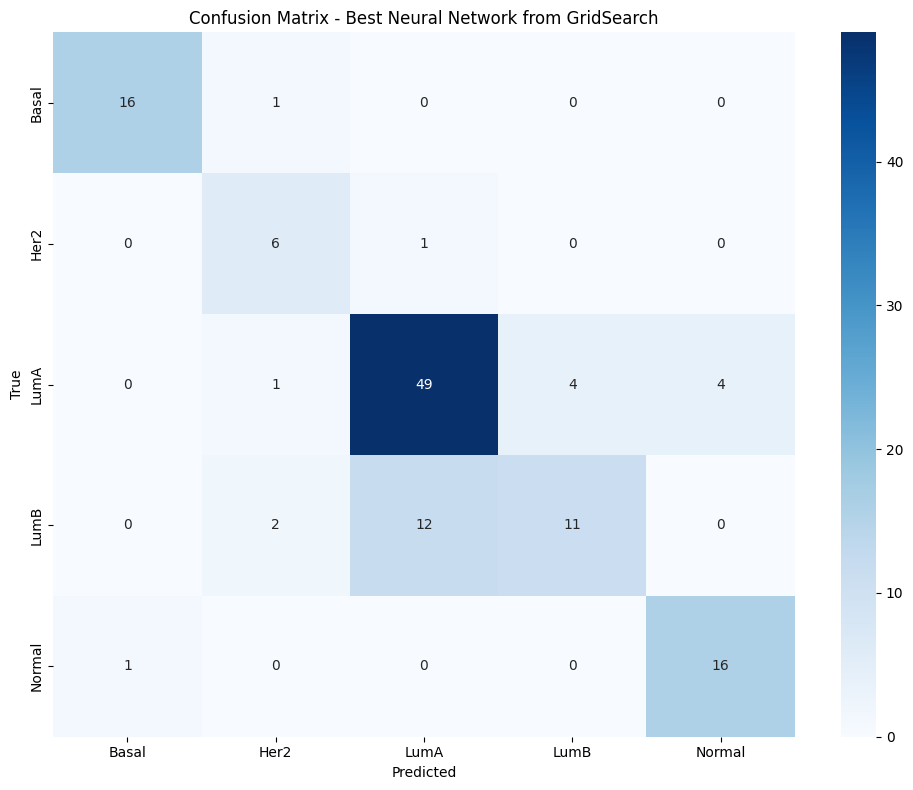


Retraining best model to visualize training history...


<Figure size 1200x500 with 0 Axes>

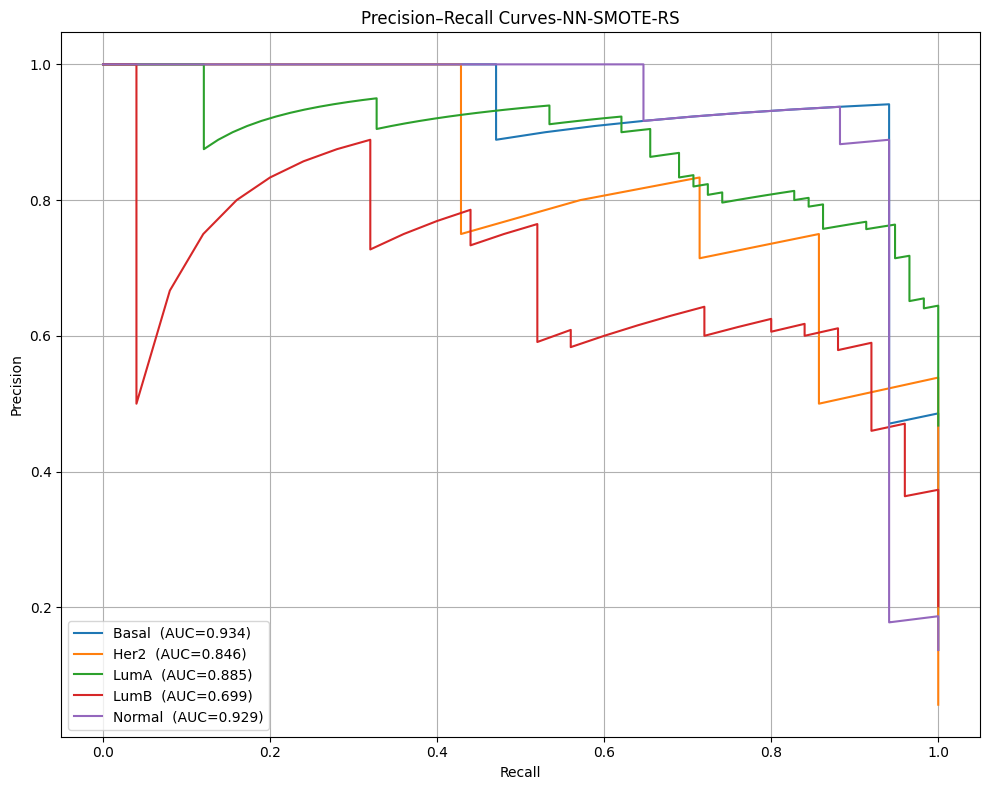

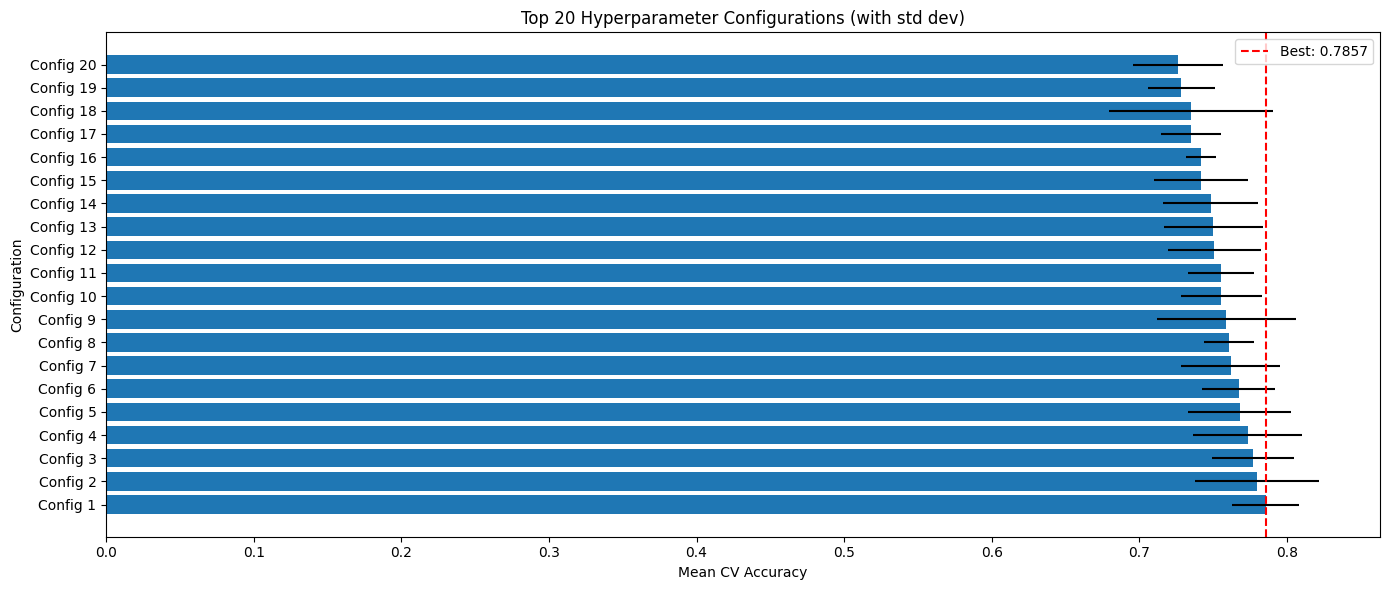


HYPERPARAMETER ANALYSIS:

nn__model__regularization:
  l1: appears 5/10 times in top 10
  None: appears 2/10 times in top 10
  l2: appears 2/10 times in top 10
  l1_l2: appears 1/10 times in top 10

nn__model__activation:
  tanh: appears 4/10 times in top 10
  relu: appears 3/10 times in top 10
  <LeakyReLU name=leaky_re_lu_2, built=True>: appears 3/10 times in top 10

nn__model__learning_rate:
  0.0001: appears 7/10 times in top 10
  1e-05: appears 2/10 times in top 10
  0.001: appears 1/10 times in top 10

nn__batch_size:
  32: appears 5/10 times in top 10
  64: appears 2/10 times in top 10
  128: appears 2/10 times in top 10
  16: appears 1/10 times in top 10

nn__model__dropout_rate1:
  0.3: appears 5/10 times in top 10
  0.1: appears 4/10 times in top 10
  0.2: appears 1/10 times in top 10

nn__model__dropout_rate2:
  0.4: appears 5/10 times in top 10
  0.5: appears 2/10 times in top 10
  0.2: appears 2/10 times in top 10
  0.3: appears 1/10 times in top 10


AttributeError: 'Pipeline' object has no attribute 'cv'

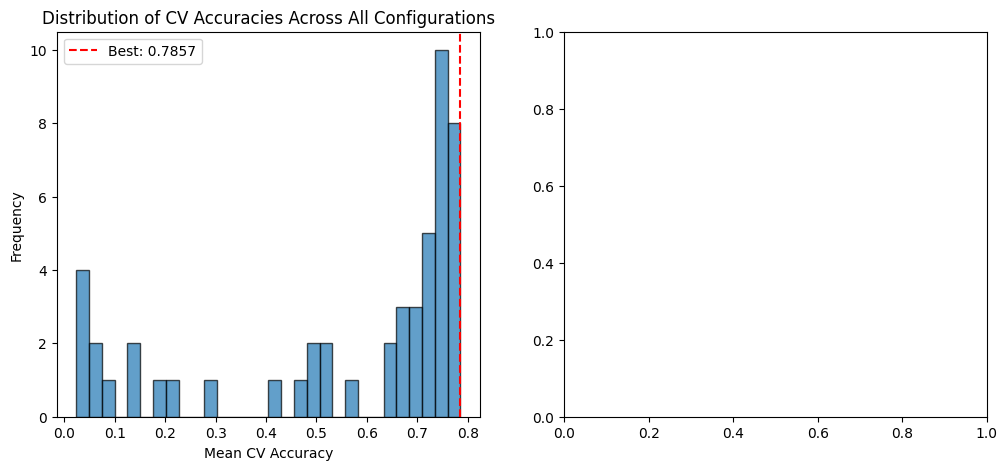

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,average_precision_score
from sklearn.preprocessing import label_binarize
import pandas as pd
from collections import Counter

# Evaluate on test set using best model from grid search
# test_acc = grid_search.score(X_test, y_test_enc)
test_acc = grid_search.score(X_test, y_test_enc)


print(f"\nTest Accuracy (Best Neural Network): {test_acc:.4f}")
y_pred_classes = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)


# Predict using best model
# y_pred_classes = grid_search.predict(X_test)

# Classification report
print("\nClassification Report (Best Neural Network):")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Best Neural Network from GridSearch')
plt.tight_layout()
plt.show()

print("\nRetraining best model to visualize training history...")

# best_params = grid_search.best_params_

#meta = {
#    "n_features_in_": X_train.shape[1],
#    "n_classes_": len(np.unique(y_train_enc))
#}

#best_model = create_nn(
#    meta=meta,
#    neurons_layer1=best_params.get('nn__model__neurons_layer1', 256),
#    neurons_layer2=best_params.get('nn__model__neurons_layer2', 128),
#    dropout_rate=best_params['nn__model__dropout_rate'],
#    learning_rate=best_params['nn__model__learning_rate'],
#    activation=best_params['nn__model__activation'],
#    regularization=best_params['nn__model__regularization']
#)

#history = best_model.fit(
#    X_train, y_train_enc,
#    validation_split=0.2,
#    epochs=100,
#    batch_size=best_params['nn__batch_size'],
#    verbose=0,
#    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
#)

#history = pipeline.fit( X_train, y_train_enc)
# -------------------------------
# TRAINING HISTORY PLOTS (if available)
# -------------------------------

if 'history' in globals():
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("\nNo training history found — skipping accuracy/loss plots.")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))



# PRECISION–RECALL CURVE
# -------------------------------
# Convert predictions into the max probability for each sample
y_score = np.max(y_pred_proba, axis=1)

# Convert true labels to 1 if correct, 0 otherwise
y_test_binarized = label_binarize(y_test_enc, classes=range(len(le.classes_)))

plt.figure(figsize=(10, 8))


for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f"{class_name}  (AUC={auc_score:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves-NN-SMOTE-RS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# GridSearch Results Visualization
# ------------------------------------------------------------------

results_df = pd.DataFrame(grid_search.cv_results_)

# Plot top 20 configurations
plt.figure(figsize=(14, 6))
top_20 = results_df.nsmallest(20, 'rank_test_score')

plt.barh(range(len(top_20)), top_20['mean_test_score'], xerr=top_20['std_test_score'])
plt.yticks(range(len(top_20)), [f"Config {i+1}" for i in range(len(top_20))])
plt.xlabel('Mean CV Accuracy')
plt.ylabel('Configuration')
plt.title('Top 20 Hyperparameter Configurations (with std dev)')
plt.axvline(x=grid_search.best_score_, color='r', linestyle='--', label=f'Best: {grid_search.best_score_:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Hyperparameter importance analysis
# ------------------------------------------------------------------

print("\n" + "="*80)
print("HYPERPARAMETER ANALYSIS:")
print("="*80)

top_10_configs = results_df.nsmallest(10, 'rank_test_score')

for param in ['nn__model__regularization', 'nn__model__activation', 
              'nn__model__learning_rate', 'nn__batch_size', 'nn__model__dropout_rate1', 'nn__model__dropout_rate2']:
    print(f"\n{param}:")
    param_values = [config[param] for config in top_10_configs['params']]
    counts = Counter(param_values)
    for value, count in counts.most_common():
        print(f"  {value}: appears {count}/10 times in top 10")

# ------------------------------------------------------------------
# CV Accuracy Distribution
# ------------------------------------------------------------------

plt.figure(figsize=(12, 5))

# Histogram of all CV accuracies
plt.subplot(1, 2, 1)
plt.hist(results_df['mean_test_score'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=grid_search.best_score_, color='r', linestyle='--', 
            label=f'Best: {grid_search.best_score_:.4f}')
plt.xlabel('Mean CV Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of CV Accuracies Across All Configurations')
plt.legend()

# Box plot (adjust to number of folds)
plt.subplot(1, 2, 2)
n_folds = pipeline.cv  # dynamically use actual folds
cv_scores = [results_df[f'split{i}_test_score'] for i in range(n_folds)]
plt.boxplot(cv_scores, labels=[f'Fold {i+1}' for i in range(n_folds)])
plt.ylabel('Accuracy')
plt.title('CV Accuracy Distribution per Fold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Summary statistics
# ------------------------------------------------------------------

print("\n" + "="*80)
print("SUMMARY STATISTICS:")
print("="*80)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Mean CV Accuracy (all configs): {results_df['mean_test_score'].mean():.4f}")
print(f"Std CV Accuracy (all configs): {results_df['mean_test_score'].std():.4f}")
print(f"Min CV Accuracy: {results_df['mean_test_score'].min():.4f}")
print(f"Max CV Accuracy: {results_df['mean_test_score'].max():.4f}")


In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from tensorflow.keras.models import Model

# ==========================================
# SETTINGS
# ==========================================
# Handle both DataFrame and numpy array inputs
if isinstance(X_train, pd.DataFrame):
    original_feature_names = X_train.columns.tolist()
else:
    # If numpy array, create generic feature names
    original_feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

MAX_BACKGROUND = 10
MAX_EXPLAIN = 10
SHAP_BATCH_SIZE = 5  # Reduced for memory efficiency
RANDOM_STATE = 42
TOP_K = 10

# MEMORY OPTIMIZATION: Reduce features for SHAP analysis
# With 578K features, SHAP is computationally infeasible
# Options: 'variance', 'model_weights', 'random', None
FEATURE_REDUCTION = 'variance'  # Set to None to use all features (not recommended)
MAX_FEATURES_FOR_SHAP = 100    # Number of features to keep for SHAP analysis

# KernelExplainer settings (only used if DeepExplainer fails)
KERNEL_NSAMPLES = 50  # Number of times to re-evaluate the model (lower = faster but less accurate)
                       # Default is 2*n_features + 2048, which would be ~4000 for 1000 features
                       # We use 100 for speed. Increase to 500-1000 for better accuracy.

OUT_DIR = "./explain_results"
os.makedirs(OUT_DIR, exist_ok=True)

# ==========================================
# MODEL EXTRACTION
# ==========================================
print("\n[MODEL] Extracting best Keras model...")
keras_model = None
try:
    keras_model = getattr(pipeline, "model_", None)
    if keras_model is None:
        keras_model = pipeline.named_steps.get("nn").model_
except Exception:
    keras_model = pipeline  # fallback

if keras_model is None:
    raise ValueError("Could not extract Keras model from best_model!")

print("Using Keras model:", type(keras_model))
print(f"Model input shape: {keras_model.input_shape}")

# ==========================================
# PREPARE DATA (GENE-LEVEL BETA VALUES)
# ==========================================
if isinstance(X_train, pd.DataFrame):
    X_train_arr = X_train.values
    X_test_arr = X_test.values
else:
    X_train_arr = X_train
    X_test_arr = X_test

print(f"Original data shape: {X_train_arr.shape}")
print(f"Total features: {len(original_feature_names)}")

# ==========================================
# FEATURE REDUCTION FOR SHAP (MEMORY OPTIMIZATION)
# ==========================================
selected_feature_indices = None
selected_feature_names = original_feature_names
use_feature_reduction = False

if FEATURE_REDUCTION and X_train_arr.shape[1] > MAX_FEATURES_FOR_SHAP:
    print(f"\n[MEMORY] Reducing features from {X_train_arr.shape[1]} to {MAX_FEATURES_FOR_SHAP} for SHAP analysis...")
    use_feature_reduction = True
    original_n_features = X_train_arr.shape[1]
    
    if FEATURE_REDUCTION == 'variance':
        # Select features with highest variance
        print("  Method: Selecting high-variance features...")
        feature_vars = np.var(X_train_arr, axis=0)
        selected_feature_indices = np.argsort(feature_vars)[-MAX_FEATURES_FOR_SHAP:]
        
    elif FEATURE_REDUCTION == 'model_weights':
        # Select features with highest absolute weights in first layer
        print("  Method: Selecting features by model input weights...")
        first_layer_weights = keras_model.layers[0].get_weights()[0]  # Shape: (n_features, hidden_dim)
        feature_importance = np.abs(first_layer_weights).sum(axis=1)
        selected_feature_indices = np.argsort(feature_importance)[-MAX_FEATURES_FOR_SHAP:]
        
    elif FEATURE_REDUCTION == 'random':
        # Random selection (for testing)
        print("  Method: Random feature selection...")
        np.random.seed(RANDOM_STATE)
        selected_feature_indices = np.random.choice(
            X_train_arr.shape[1], 
            size=MAX_FEATURES_FOR_SHAP, 
            replace=False
        )
    
    # Sort indices to maintain order
    selected_feature_indices = sorted(selected_feature_indices)
    selected_feature_names = [original_feature_names[i] for i in selected_feature_indices]
    
    # Store the reduced data separately for SHAP
    X_train_reduced = X_train_arr[:, selected_feature_indices]
    X_test_reduced = X_test_arr[:, selected_feature_indices]
    
    print(f"  ✓ Reduced to {len(selected_feature_indices)} features")
    print(f"  ✓ Memory footprint reduced by {100*(1 - MAX_FEATURES_FOR_SHAP/original_n_features):.1f}%")
    
    # Save selected feature indices for reference
    selected_df = pd.DataFrame({
        'Original_Index': selected_feature_indices,
        'Feature_Name': selected_feature_names
    })
    selected_df.to_csv(os.path.join(OUT_DIR, "selected_features_for_shap.csv"), index=False)
    print(f"  ✓ Selected features saved to selected_features_for_shap.csv")
else:
    print(f"\n[INFO] Using all {X_train_arr.shape[1]} features for SHAP analysis")
    X_train_reduced = X_train_arr
    X_test_reduced = X_test_arr

print(f"SHAP analysis will use {len(selected_feature_names)} features")

# ==========================================
# SHAP EXPLANATIONS
# ==========================================
def shap_sample_fallback(X, n, random_state):
    """Sample data for SHAP background/explanation sets"""
    if hasattr(shap, "sample"):
        return shap.sample(X, n, random_state=random_state)
    else:
        idx = np.random.RandomState(random_state).choice(len(X), size=n, replace=False)
        return X[idx]

# Sample background and test data (using reduced features)
small_bg = shap_sample_fallback(X_train_reduced, min(MAX_BACKGROUND, len(X_train_reduced)), RANDOM_STATE)
small_test = shap_sample_fallback(X_test_reduced, min(MAX_EXPLAIN, len(X_test_reduced)), RANDOM_STATE)

print(f"\n[SHAP] Background samples: {small_bg.shape[0]}")
print(f"[SHAP] Test samples: {small_test.shape[0]}")

# Create a wrapper that expands reduced features back to full input
if use_feature_reduction:
    print(f"[SHAP] Creating model wrapper for feature expansion...")
    
    # Create a template with zeros for all features
    def model_wrapper_with_expansion(X_reduced):
        """Expands reduced features to full input size with zeros for non-selected features"""
        batch_size = X_reduced.shape[0]
        X_full = np.zeros((batch_size, original_n_features))
        X_full[:, selected_feature_indices] = X_reduced
        return keras_model.predict(X_full, batch_size=32, verbose=0)
    
    model_wrapper = model_wrapper_with_expansion
else:
    def model_wrapper(X):
        return keras_model.predict(X, batch_size=32, verbose=0)

# Try DeepExplainer first, fall back to KernelExplainer
try:
    print("\n[SHAP] Attempting DeepExplainer...")
    if use_feature_reduction:
        print("  Note: DeepExplainer may not work well with feature reduction")
        print("  Skipping to KernelExplainer...")
        raise Exception("Using KernelExplainer for feature reduction")
    
    explainer = shap.DeepExplainer(keras_model, small_bg)
    shap_values = explainer.shap_values(small_test, check_additivity=False)
    expected_value = explainer.expected_value
    use_deep = True
    print("  ✓ DeepExplainer successful")
except Exception as e:
    print(f"  ✗ DeepExplainer failed: {e}")
    print("\n[SHAP] Using KernelExplainer with batch processing...")
    
    explainer = shap.KernelExplainer(model_wrapper, small_bg)
    shap_values_list = []
    total_batches = int(np.ceil(len(small_test) / SHAP_BATCH_SIZE))
    
    for i in range(0, len(small_test), SHAP_BATCH_SIZE):
        batch_end = min(i + SHAP_BATCH_SIZE, len(small_test))
        batch = small_test[i:batch_end]
        print(f"  Processing batch {i//SHAP_BATCH_SIZE + 1}/{total_batches}...")
        batch_shap = explainer.shap_values(batch)
        shap_values_list.append(batch_shap)
        gc.collect()
    
    # Combine batches
    if isinstance(shap_values_list[0], list):
        n_classes = len(shap_values_list[0])
        shap_values = [np.vstack([b[c] for b in shap_values_list]) for c in range(n_classes)]
    else:
        shap_values = np.vstack(shap_values_list)
    
    expected_value = explainer.expected_value
    use_deep = False
    print("  ✓ KernelExplainer successful")

del explainer
gc.collect()

# Convert list of arrays to 3D array if needed
if isinstance(shap_values, list):
    shap_values = np.stack([np.array(s) for s in shap_values], axis=2)

print(f"\n[SHAP] SHAP values shape: {shap_values.shape}")

# ==========================================
# OVERALL FEATURE IMPORTANCE
# ==========================================
print("\n[SHAP] Computing overall feature importance...")

if shap_values.ndim == 3:
    # Multi-class: take max absolute SHAP across classes
    shap_values_overall = np.abs(shap_values).max(axis=2)
else:
    # Binary or regression
    shap_values_overall = np.abs(shap_values)

mean_abs_shap_overall = shap_values_overall.mean(axis=0)
shap_importances_overall = pd.DataFrame({
    "Feature": selected_feature_names,
    "MeanAbsSHAP_MaxAcrossClasses": mean_abs_shap_overall
}).sort_values(by="MeanAbsSHAP_MaxAcrossClasses", ascending=False)

top_features_overall = shap_importances_overall.head(TOP_K)
top_features_overall.to_csv(os.path.join(OUT_DIR, "top_features_overall.csv"), index=False)

# Plot overall importance
plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_overall,
            x="MeanAbsSHAP_MaxAcrossClasses",
            y="Feature",
            palette="Greens_d")
plt.title(f"Top {TOP_K} Most Important Features (Overall)")
plt.xlabel("Mean |SHAP| Value")
plt.ylabel("Gene Feature")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "top10_overall_bar.png"), dpi=150)
plt.close()

print("\n=== Top 10 Most Important Features (Overall) ===")
print(top_features_overall)

# ==========================================
# EXTRACT CLASS LABELS
# ==========================================
try:
    if hasattr(pipeline, 'classes_'):
        class_names = pipeline.classes_.tolist()
    elif hasattr(pipeline, 'named_steps') and 'nn' in pipeline.named_steps:
        if hasattr(pipeline.named_steps['nn'], 'classes_'):
            class_names = pipeline.named_steps['nn'].classes_.tolist()
        else:
            class_names = None
    else:
        class_names = None
    
    if class_names is None and 'y_train' in globals():
        class_names = sorted(y_train.unique().tolist())
    
    print(f"\n[SHAP] Detected class names: {class_names}")
except Exception as e:
    print(f"[SHAP] Could not extract class names: {e}")
    class_names = None

# ==========================================
# PER-CLASS SHAP ANALYSIS
# ==========================================
if shap_values.ndim == 3:
    n_classes = shap_values.shape[2]
    print(f"\n[SHAP] Creating summary plots for {n_classes} classes...")
    
    # Get original test data for plotting
    if isinstance(X_test, pd.DataFrame):
        X_test_original = X_test.values[:len(small_test)]
    else:
        X_test_original = X_test[:len(small_test)]
    
    # Extract only the selected features for plotting
    if use_feature_reduction:
        X_test_for_plot = X_test_original[:, selected_feature_indices]
    else:
        X_test_for_plot = X_test_original
    
    for class_idx in range(n_classes):
        class_label = class_names[class_idx] if class_names else f"Class {class_idx}"
        class_shap = shap_values[:, :, class_idx]
        
        print(f"\n  Processing {class_label}...")
        
        # Summary plot (beeswarm) - Shows distribution of SHAP values
        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            class_shap,
            X_test_for_plot,
            feature_names=selected_feature_names,
            max_display=TOP_K,
            show=False
        )
        plt.title(f"SHAP Summary Plot - {class_label}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"shap_summary_{class_label.lower().replace(' ', '_')}.png"), 
                   dpi=150, bbox_inches='tight')
        plt.close()
        
        # Bar plot (mean absolute SHAP) - Shows feature importance
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            class_shap,
            X_test_for_plot,
            feature_names=selected_feature_names,
            max_display=TOP_K,
            plot_type="bar",
            show=False
        )
        plt.title(f"SHAP Feature Importance - {class_label}", fontsize=14, pad=20)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"shap_bar_{class_label.lower().replace(' ', '_')}.png"), 
                   dpi=150, bbox_inches='tight')
        plt.close()
        
        # Save class-specific importance to CSV
        mean_abs_shap_class = np.abs(class_shap).mean(axis=0)
        class_importance = pd.DataFrame({
            "Feature": selected_feature_names,
            "MeanAbsSHAP": mean_abs_shap_class
        }).sort_values(by="MeanAbsSHAP", ascending=False)
        class_importance.to_csv(
            os.path.join(OUT_DIR, f"top_features_{class_label.lower().replace(' ', '_')}.csv"), 
            index=False
        )
        
        print(f"    Top 5 features for {class_label}:")
        print(class_importance.head(5).to_string(index=False))
        print(f"  ✓ {class_label} summary plots saved")
    
    print(f"\n✓ Summary plots for all {n_classes} classes completed")
    
else:
    # Binary classification or regression
    print("\n[SHAP] Creating summary plots (single output)...")
    
    if isinstance(X_test, pd.DataFrame):
        X_test_original = X_test.values[:len(small_test)]
    else:
        X_test_original = X_test[:len(small_test)]
    
    # Extract only the selected features for plotting
    if use_feature_reduction:
        X_test_for_plot = X_test_original[:, selected_feature_indices]
    else:
        X_test_for_plot = X_test_original
    
    # Beeswarm plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(
        shap_values,
        X_test_for_plot,
        feature_names=selected_feature_names,
        max_display=TOP_K,
        show=False
    )
    plt.title("SHAP Summary Plot", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_summary.png"), dpi=150, bbox_inches='tight')
    plt.close()
    
    # Bar plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values,
        X_test_for_plot,
        feature_names=selected_feature_names,
        max_display=TOP_K,
        plot_type="bar",
        show=False
    )
    plt.title("SHAP Feature Importance", fontsize=14, pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "shap_bar.png"), dpi=150, bbox_inches='tight')
    plt.close()
    
    print("  ✓ Summary plots saved")

# ==========================================
# SUMMARY
# ==========================================
print("\n" + "="*50)
print("✅ SHAP ANALYSIS COMPLETE!")
print("="*50)
print(f"📁 Results saved to: {OUT_DIR}")
print("\n📊 Generated files:")
print("   ✓ Overall feature importance (CSV + bar plot)")
if shap_values.ndim == 3:
    print(f"   ✓ Per-class summary plots (beeswarm + bar) for {n_classes} classes")
    print(f"   ✓ Per-class feature importance CSVs for {n_classes} classes")
else:
    print("   ✓ Summary plots (beeswarm + bar)")
print("\n💡 Interpretation:")
print("   - Beeswarm plots show how feature values affect predictions")
print("   - Bar plots show overall feature importance by mean |SHAP|")
print("   - Red = high feature value, Blue = low feature value")
print("="*50)


[MODEL] Extracting best Keras model...
Using Keras model: <class 'keras.src.models.sequential.Sequential'>
Model input shape: (None, 19277)
Original data shape: (496, 19277)
Total features: 19277

[MEMORY] Reducing features from 19277 to 100 for SHAP analysis...
  Method: Selecting high-variance features...
  ✓ Reduced to 100 features
  ✓ Memory footprint reduced by 99.5%
  ✓ Selected features saved to selected_features_for_shap.csv
SHAP analysis will use 100 features

[SHAP] Background samples: 10
[SHAP] Test samples: 10
[SHAP] Creating model wrapper for feature expansion...

[SHAP] Attempting DeepExplainer...
  Note: DeepExplainer may not work well with feature reduction
  Skipping to KernelExplainer...
  ✗ DeepExplainer failed: Using KernelExplainer for feature reduction

[SHAP] Using KernelExplainer with batch processing...
  Processing batch 1/2...


  0%|          | 0/5 [00:01<?, ?it/s]


MemoryError: Unable to allocate 3.23 GiB for an array with shape (22480, 19277) and data type float64

In [ ]:
rf = best_model.named_steps['rf']

if len(original_feature_names) != len(rf.feature_importances_):
    print(f"Warning: Number of feature names ({len(original_feature_names)}) doesn't match number of features used ({len(rf.feature_importances_)})")
    # Use generic names if there's a mismatch
    feature_names = [f'Feature {i}' for i in range(len(rf.feature_importances_))]
else:
    feature_names = original_feature_names

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 20 features
top_n = 20
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importance.head(top_n), x='Importance', y='Feature')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

print("Top 20 features by importance:")
print(feature_importance['Feature'].head(20).tolist())

AttributeError: 'Sequential' object has no attribute 'named_steps'